# Rendimiento Académico de los Estudiantes

**Enzo N. Manolucos**

Este es un caso de aplicación de aprendizaje automático utilizando el conjunto de datos *Student Performance* de la [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/320/student+performance). El objetivo es predecir el rendimiento académico de los estudiantes en función de diversas características.

## Datos

### Introducción a la problemática

En el año 2008, Paulo Cortez y Alice Silva del Departamento de Informática de la Universidad de Minho, Portugal, publicaron [*Using Data Mining to Predict Secondary School Student Performance*](../data/Using%20Data%20Mining%20to%20Predict%20Secondary%20School%20Student%20Performance.pdf). En esta publicación se indica que **Portugal se mantiene como uno de los países con menor rendimiento académico en Europa, en especial en las materias de matematicas y lengua portuguesa.** 

Para abordar este problema, los autores realizaron un estudio utilizando técnicas de minería de datos para **predecir el rendimiento académico de estudiantes de secundaria.**

Los datos fueron recolectados de dos escuelas secundarias en Portugal mediante reportes y cuestionarios durante los años 2005 y 2006. Portugal tiene un sistema de calificacion que va de 0 a 20, donde **10 es la nota mínima para aprobar**. Finalmente los datos fueron integrados en: Matematicas (con 395 datos) y Lengua Portuguesa (con 649 datos). Ambos incluyen variables demográficas, sociales y académicas. 

### Variables utilizadas

Para este caso de análisis, se opto por utilizar el conjunto de datos de **Lengua Portuguesa** con las siguientes variables:

- **studytime:** Tiempo de estudio semanal, 1 para menor a 2 h, 2 para 2-5 h, 3 para 5-10 h, 4 para más 
de 10 h.
- **failures:** Número de materias desaprobadas, con _n_ si 1 <= _n_ < 3, y con 4 si _n_ >= 3.
- **schoolsup:** Apoyo escolar adicional, con 1 = sí y 0 = no.
- **famsup:** Apoyo escolar familiar, con 1 = sí y 0 = no.
- **activities:** Participación en actividades extracurriculares, con 1 = sí y 0 = no.
- **paid:** Clases particulares adicionales, con 1 = sí y 0 = no.
- **internet:** Acceso a internet en casa, con 1 = sí y 0 = no.
- **higher:** Aspiración a educación superior, con 1 = sí y 0 = no.
- **absences:** Número de faltas, de 0 a 93.
- **G1:** Nota del primer periodo, de 0 a 20.
- **G2:** Nota del segundo periodo, de 0 a 20.
- **G3:** Nota del tfinal, de 0 a 20.

Se obtiene un conjunto de datos de 649 filas y 12 variables numéricas.

## Configuración del entorno


Se empieza por importar las librerias necesarias para el desarrollo y algunas configuraciones iniciales.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, roc_auc_score, silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from xgboost import XGBClassifier

from tabulate import tabulate
from skopt import BayesSearchCV
from skopt.space import Real, Integer

pd.set_option('display.max_columns', None)
data_path = "../data/uciml/student-performance.csv"
random_state = 6
cmap = plt.get_cmap("coolwarm")

El conjutno de datos se carga en la vartiable `df` y se realiza una inspección inicial de los datos mediante la función `sample()`. 

In [2]:
df = pd.read_csv(data_path, sep=';',)
df.sample(5)

,studytime,failures,schoolsup,famsup,paid,activities,higher,internet,absences,G1,G2,G3
267,2,0,0,0,0,1,1,1,8,15,15,15
66,4,0,0,1,0,1,1,1,0,11,12,12
297,1,0,0,0,0,0,0,0,0,9,10,10
346,1,0,0,0,0,0,1,1,0,12,13,13
0,2,0,1,0,0,0,1,0,4,0,11,11


In [3]:
print(df.shape)

(649, 12)


### Visualización de los datos

Con la funcion `plot_histograms()` se visualizan los histogramas de las variables para ver su distribución. 

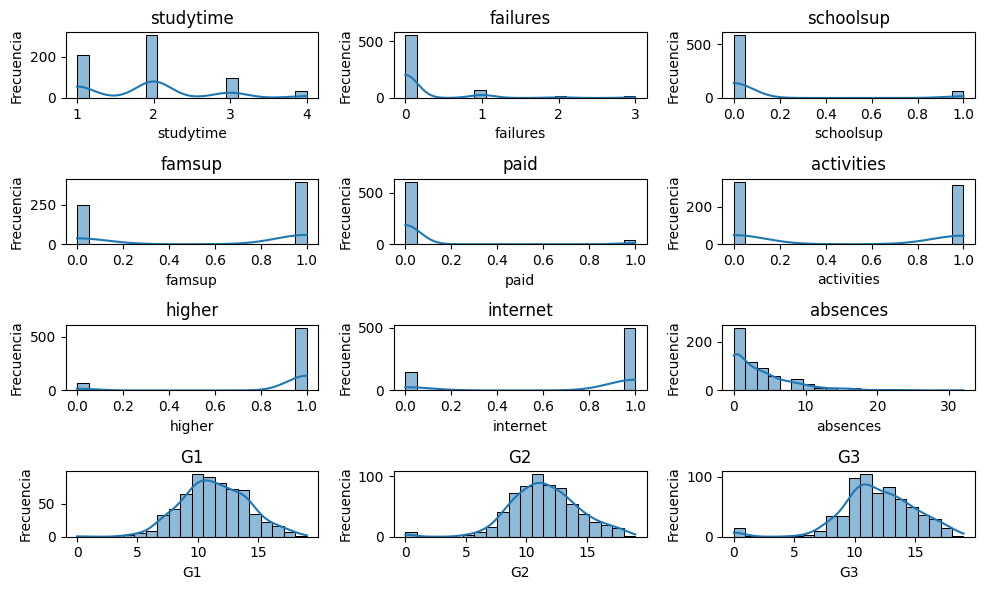

In [4]:
def plot_histograms(df, columns=None, bins=20, cols=3, figsize=(10, 6)):
    if columns is None:
        columns = df.select_dtypes(include='number').columns
    n = len(columns)
    rows = (n + cols - 1) // cols 
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()
    for i, col in enumerate(columns):
        sns.histplot(df[col], bins=bins, kde=True, ax=axes[i])
        axes[i].set_title(col)
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frecuencia')
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    plt.tight_layout()
    plt.show()

plot_histograms(df, cols=3)

## Aprendizaje Supervisado 

Es un tipo de paradigma de aprendizaje automático donde un modelo aprende a mapear datos de entrada a una salida especifica basado en pares de ejemplos de entrada y salida etiquetados. **El objetivo del modelo es predecir la salida correcta para nuevas entradas no etiquetadas.**

Para este caso, el objetivo es predecir la nota final de los estudiantes (G3) en función de las demás variables. Se crea una nueva variable llamada `pass` con datos que contiene la nota final (G3) con 1 si la nota es mayor o igual a 10 (aprobado) y 0 si es menor a 10 (desaprobado). Esta será la variable **objetivo**.

In [5]:
df_sl = df.copy()   # Realizamos una copia del DataFrame original
df_sl['pass'] = (df_sl['G3'] >= 10).astype(int)
df_sl.sample(5)

,studytime,failures,schoolsup,famsup,paid,activities,higher,internet,absences,G1,G2,G3,pass
109,3,0,0,1,0,1,1,1,2,15,15,14,1
289,4,0,0,1,0,1,1,1,2,14,15,17,1
458,4,0,0,1,0,0,1,1,0,13,10,13,1
521,2,0,0,1,0,1,1,1,0,8,10,10,1
601,2,0,0,1,0,0,1,1,4,8,8,10,1


### Preparación de los datos

La variable a predecir es `pass` y sabiendo que los datos solo pueden ser 0 o 1, se trata de un problema de **clasificación binaria**. Se separan las variables en datos de entrada `X` y la variable objetivo `y`.

In [6]:
X = df_sl.drop(columns=['G3', 'pass'])
y = df_sl['pass']

Antes de crear el modelo vamos a ver la distribución de la variable objetivo

In [7]:
print("y:")
print(y.value_counts(normalize=True))
print(y.value_counts())

y:
pass
1    0.845917
0    0.154083
Name: proportion, dtype: float64
pass
1    549
0    100
Name: count, dtype: int64


La variable `pass` no tiene igual cantidad de alumnos aprobados y desaprobados. Este desbalance puede llamar la atención pero refleja la realidad de los datos. El modelo debe aprender estas relaciones y debemos asegurarnos que tenga los datos y distribuciones necesarias para hacerlo.

El modelo primero se debe entrenar para luego evaluarlo. Con los resultados de los test se puede determinar que tan bueno es el modelo. Mediante `train_test_split()` se separan los datos en 80% de entrenamiento y 20% para test.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

print("y_train:")
print(y_train.value_counts(normalize=True))
print(y_train.value_counts())
print("\ny_test:")
print(y_test.value_counts(normalize=True))
print(y_test.value_counts())

y_train:
pass
1    0.840077
0    0.159923
Name: proportion, dtype: float64
pass
1    436
0     83
Name: count, dtype: int64

y_test:
pass
1    0.869231
0    0.130769
Name: proportion, dtype: float64
pass
1    113
0     17
Name: count, dtype: int64


Algunos problemas de clasificación no tienen un número equilibrado de ejemplos para cada etiqueta de clase. Por lo tanto, es conveniente dividir el conjunto de datos en entrenamiento y test de manera que se conserven las mismas proporciones de ejemplos en cada clase que en el conjunto original. A esto se le llama división estratificada (*stratified train-test split*).

Podemos lograrlo configurando el argumento `stratify` con el componente `y` del conjunto de datos original. La función `train_test_split()` usará este parámetro para garantizar que tanto el conjunto de entrenamiento como el de test mantengan la proporción de ejemplos en cada clase presente en el arreglo y proporcionado.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

print("y_train:")
print(y_train.value_counts(normalize=True))
print(y_train.value_counts())

print("\ny_test:")
print(y_test.value_counts(normalize=True))
print(y_test.value_counts())

y_train:
pass
1    0.845857
0    0.154143
Name: proportion, dtype: float64
pass
1    439
0     80
Name: count, dtype: int64

y_test:
pass
1    0.846154
0    0.153846
Name: proportion, dtype: float64
pass
1    110
0     20
Name: count, dtype: int64


El siguiente paso es escalar los datos. Esto hace que todas las variables tengan los mismos rangos y asi evitar sesgos dentro del mismo modelo. Para los modelos basados en arboles (Random Forest y XGBoost) no es necesaria porque solo utilizan las variables para hacer las divisiones, por ejemplo: ¿la característica A > 0?”, no importa si los datos están escalados o no. Para modelos basados en distancias (SVM) es necesario escalar los datos para que todos los datos esten en el mismo rango.

Luego se separan los datos en entrenamiento y test. El conjunto de entrenamiento se usa para entrenar el modelo, mientras que el test se reserva para la evaluación final.
Si queremos mejorar el modelo, ajustando sus hiperparámetros, no debemos usar el test para esto, porque se optimizaria sobre esos datos y la métrica dejaría de reflejar el rendimiento en datos realmente nuevos y desconocidos.
En su lugar, dentro del conjunto de entrenamiento se reserva una pequeña porción, llamado datos de validación, para ajustar los hiperparámetros. De esta forma, la evaluación final de todos los modelos se hace únicamente con el conjunto test, que no ha intervenido en el entrenamiento ni en el ajuste.

Se puede separar en tres conjuntos de datos (train, val y test) o usar otra estrategia: **K-Fold Cross-Validation**.
En este método, el conjunto de entrenamiento se divide en K partes (*folds*). Se entrena el modelo K veces, cada vez usando K-1 *folds* para entrenar y el *fold* restante para validar. Esto rota hasta que cada *fold* haya sido validación una vez.
En clasificación, es recomendable usar **StratifiedKFold** para que en cada *fold* se mantenga la misma proporción de clases que en el conjunto original.

<img src="../data/images/sphx_glr_plot_cv_indices_009.png" alt="K-Fold Cross-Validation Stratified K Fold" width="600"/>


Este enfoque aprovecha mejor los datos, da una evaluación más robusta que una sola división train/val, y mantiene el conjunto test completamente aislado hasta la evaluación final. En este caso se definene 10 *folds*:


In [10]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

En casos de clasificación binaria con clases desbalanceadas, las métricas clásicas como *accuracy* (precisión) no son muy confiables, porque un modelo que predice siempre la clase mayoritaria ya tendría un *accuracy* alto sin realmente aprender a distinguir.

Se proponen las siguientes métricas:

- **AUC-ROC:** mide la capacidad del modelo para separar las clases en distintos umbrales, independiente del umbral fijo. Es muy usada con clases desbalanceadas. El área bajo la curva representa la probabilidad de que el modelo, si se le da un ejemplo positivo y negativo elegido al azar, clasifique el positivo más alto que el negativo.
- **F1-Score:** combina *precisión* y *recall* en una sola métrica. Te da un balance entre falsos positivos y falsos negativos.

Se evaluaran los siguientes modelos:

- Random Forest
- XGBoost
- Support Vector Machine

### Random Forest

Propuesto en el 2001, *Random Forest* es una combinación de múltiples árboles de decisón, donde cada árbol se entrena sobre un subconjunto aleatorio de datos. Esta aleatoriedad, generada de forma independiente por cada árbol, mejora la diversidad del conjunto y reduce el riesgo de sobreajuste.

Primero, se instancia el modelo y se evalúa mediante 10 folds:

In [11]:
rf = RandomForestClassifier(random_state=random_state)

scores = cross_validate(
    rf,
    X_train,
    y_train,
    cv=cv,
    scoring=['roc_auc', 'f1'],
    return_train_score=False

)

metrics_table = [
    ["ROC-AUC", [f"{v:.4f}" for v in scores['test_roc_auc']], f"{scores['test_roc_auc'].mean():.4f}"],
    ["F1 Score", [f"{v:.4f}" for v in scores['test_f1']], f"{scores['test_f1'].mean():.4f}"]
]

print(tabulate(metrics_table, headers=["Métrica", "Scores por fold", "Media"], tablefmt="github"))

| Métrica   | Scores por fold                                                                                      |   Media |
|-----------|------------------------------------------------------------------------------------------------------|---------|
| ROC-AUC   | ['0.9432', '0.9943', '0.9744', '0.9815', '0.9631', '0.9901', '0.9801', '0.9744', '0.9659', '0.8692'] |  0.9636 |
| F1 Score  | ['0.9556', '0.9885', '0.9425', '0.9778', '0.9425', '0.9773', '0.9778', '0.9655', '0.9348', '0.9663'] |  0.9629 |


In [12]:
rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Si bien los resultados medidos mediante ROC-AUC y F1-Score son muy buenos, aún hay margen para mejorar los resultados ajustando los hiperparámetros mediante **Optimización Bayesiana**.

A diferencia de **Grid Search** y **Random Search**, que prueban combinaciones de hiperparámetros de forma exhaustiva o aleatoria sin considerar el valor de intentos previos, la Optimización Bayesiana adopta un enfoque más inteligente. 

Trata el ajuste de hiperparámetros como un problema de optimización matemática, aprendiendo de los resultados anteriores para estimar qué combinaciones son más prometedoras y probarlas en siguiente lugar, reduciendo así el número de evaluaciones necesarias.

Se establece el rango de hiperparámetros a optimizar y se vuelve a entrenar el modelo:

In [13]:
param_rf = {
    # Número de árboles: 
    # Más árboles puede generar mejor rendimiento pero tiempos de entranamiento más largos
    'n_estimators': Integer(50, 300),

    # Profundidad máxima: 
    # Valores altos pueden llevar a overfitting pero valores muy bajos pueden no capturar la complejidad de los datos
    'max_depth': Integer(3, 30),

    # Número mínimo de muestras requeridas para dividir un nodo interno:
    # Valores más altos pueden prevenir overfitting pero valores muy bajos pueden llevar a árboles muy profundos
    'min_samples_split': Integer(2, 20),

    # Número mínimo de muestras requeridas para ser una hoja:
    # Valores más altos pueden prevenir overfitting pero valores muy bajos pueden llevar a árboles muy profundos
    'min_samples_leaf': Integer(1, 20),

    # Número de características a considerar al buscar la mejor división:
    # Valores más altos pueden llevar a árboles más complejos pero también a overfitting
    # Valores bajos pueden llevar a árboles más simples pero con menor capacidad de generalización
    'max_features': Real(0.1, 1.0, prior='uniform')
}

In [14]:
rf_opt = BayesSearchCV(
    estimator=rf,
    search_spaces=param_rf,
    n_iter=30,  # Número de iteraciones 
    scoring='roc_auc',
    cv=cv,
    random_state=random_state,
    n_jobs=-1,
    verbose=1
)

rf_opt.fit(X_train, y_train)

print("Mejores hiperparámetros encontrados:")
print(rf_opt.best_params_)
print(f"ROC-AUC: {rf_opt.best_score_:.4f}")

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for eac

In [15]:
rf_opt

,estimator,RandomForestC...andom_state=6)
,search_spaces,"{'max_depth': Integer(low=3...m='normalize'), 'max_features': Real(low=0.1,...m='normalize'), 'min_samples_leaf': Integer(low=1...m='normalize'), 'min_samples_split': Integer(low=2...m='normalize'), ...}"
,optimizer_kwargs,None
,n_iter,30
,scoring,'roc_auc'
,fit_params,None
,n_jobs,-1
,n_points,1
,iid,'deprecated'
,refit,True
,cv,StratifiedKFo... shuffle=True)


In [16]:
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

y_pred_rf_opt = rf_opt.predict(X_test)
y_prob_rf_opt = rf_opt.predict_proba(X_test)[:, 1]

roc_auc_rf = roc_auc_score(y_test, y_prob_rf)
roc_auc_rf_opt = roc_auc_score(y_test, y_prob_rf_opt)

f1_rf = f1_score(y_test, y_pred_rf)
f1_rf_opt = f1_score(y_test, y_pred_rf_opt)

print("Random Forest:\n")

print(f"ROC-AUC:\t{roc_auc_rf:.4f}")
print(f"ROC-AUC (Opt.):\t{roc_auc_rf_opt:.4f}")
print(f"F1:\t\t{f1_rf:.4f}")
print(f"F1 (Opt.):\t{f1_rf_opt:.4f}")

Random Forest:

ROC-AUC:	0.9405
ROC-AUC (Opt.):	0.9573
F1:		0.9417
F1 (Opt.):	0.9511


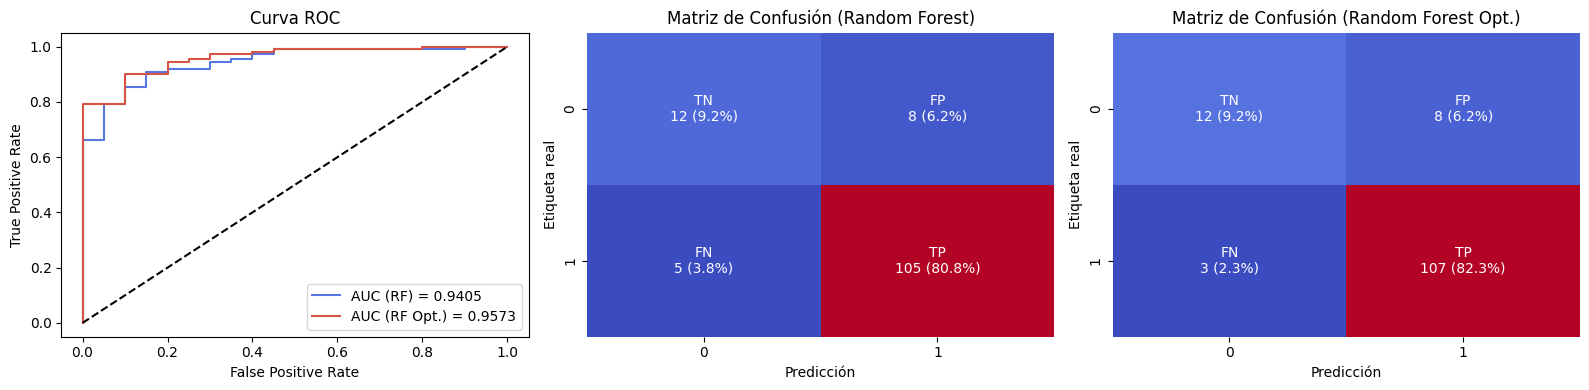

In [17]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_prob_rf)
fpr_rf_opt, tpr_rf_opt, thresholds_rf_opt = roc_curve(y_test, y_prob_rf_opt)

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.step(fpr_rf, tpr_rf, label=f'AUC (RF) = {roc_auc_rf:.4f}', color=cmap(0.1))
plt.step(fpr_rf_opt, tpr_rf_opt, label=f'AUC (RF Opt.) = {roc_auc_rf_opt:.4f}', color=cmap(0.9))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()

cm = confusion_matrix(y_test, y_pred_rf)
cm_percent = cm / cm.sum() * 100
labels = np.array([["TN", "FP"], ["FN", "TP"]])
annot = np.empty_like(cm).astype(str)
for i in range(2):
    for j in range(2):
        annot[i, j] = f"{labels[i, j]}\n{cm[i, j]} ({cm_percent[i, j]:.1f}%)"

plt.subplot(1, 3, 2)
sns.heatmap(cm, annot=annot, fmt='', cmap='coolwarm', cbar=False)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta real')
plt.title('Matriz de Confusión (Random Forest)')

cm = confusion_matrix(y_test, y_pred_rf_opt)
cm_percent = cm / cm.sum() * 100
annot = np.empty_like(cm).astype(str)
for i in range(2):
    for j in range(2):
        annot[i, j] = f"{labels[i, j]}\n{cm[i, j]} ({cm_percent[i, j]:.1f}%)"

plt.subplot(1, 3, 3)
sns.heatmap(cm, annot=annot, fmt='', cmap='coolwarm', cbar=False)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta real')
plt.title('Matriz de Confusión (Random Forest Opt.)')

plt.tight_layout()
plt.show()

La curva ROC evalúa el desempeño de un clasificador binario en distintos umbrales de decisión, tambien conocido como *threshold*. El *threshold* transforma la probabilidad estimada de pertenener a la clase positiva (en este caso, aprobar) en una predicción binaria: si la probabilidad es mayor o igual al *threshold* , el alumno se clasifica como aprobado, en caso contrario, como no aprobado (desaprobado).

El eje Y representa la tasa de verdaderos positivos (TPR), es decir, la proporción de alumnos aprobados que el modelo **clasifica correctamente** como aprobados. El eje X representa la tasa de falsos positivos (FPR), la proporción de alumnos no aprobados (desaprobados) que fueron **incorrectamente clasificados** como aprobados.

Cada punto de la curva corresponde a un valor de *threshold* distinto, indicando el compromiso entre sensibilidad y falsos positivos. El punto (0, 0) indica un clasificador extremadamente conservador (*threshold* máximo), que no predice a ningún alumno como aprobado: no tiene falsos positivos (FPR = 0) pero tampoco identifica a ningún aprobado (TPR = 0). El punto (1, 1) representa el caso opuesto: un clasificador que predice siempre la clase positiva, logrando TPR = 1 pero también FPR = 1. El punto (0.4, 1) del Random Forest Optimizado indica que el modelo clasifica correctamente al 100% de los alumnos aprobados como aprobados (TPR = 1) pero al mismo tiempo clasifica erroneamente al 40% de los alumnos no aprobados (desaprobados) como aprobados (FPR = 0.4).  

La diagonal corresponde a un clasificador aleatorio, que no discrimina entre aprobados y no aprobados. Un modelo que sigue esa diagonal tiene un AUC = 0.5. Cuanto más se aleja la curva ROC hacia la esquina superior izquierda (cercana a TPR = 1 y FPR = 0), mejor es la capacidad de discriminación del modelo.

El área bajo la curva ROC (AUC) cuantifica este rendimiento global independientemente del umbral. Un AUC = 0.5 indica desempeño aleatorio, mientras que un AUC = 1 corresponde a un clasificador perfecto. En este caso, Random Forest base obtiene un AUC de **0.9405**, mientras que el modelo optimizado alcanza **0.9573**, indicando una mejora significativa en la discriminación entre alumnos aprobados y no aprobados.


### XGBoost

Otra librería muy popular basada en árboles de decisión es *XGBoost*. Se hizo conocida porque durante mucho tiempo fue la opción más competitiva en diferentes competencias de aprendizaje automático.

Está basada en el algoritmo de **Gradient Boosting**, que combina múltiples predicciones de modelos "debiles", en este caso arboles, en un solo modelo más potente. Su principal ventaja es que reduce la función de pérdida de manera iterativa, corrigiendo errores en cada paso y mejorando progresivamente su precisión.

También incorpora regularización (L1 y L2) para evitar *overfitting*. La regularización L1 (Lasso) tiende a eliminar ramas irrelevantes al forzar algunos pesos a cero, mientras que la regularización L2 (Ridge) suaviza los valores de los pesos para mantener el modelo más estable y menos propenso a sobreajustar.

Primerp, se instancia el modelo y se evalúa mediante 10 folds:

In [18]:
xgb = XGBClassifier(random_state=random_state, objective='binary:logistic', eval_metric='auc') # Indicar el objetivo del aprendizaje

In [19]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

scores = cross_validate(
    xgb,
    X_train,
    y_train,
    cv=cv,
    scoring=['roc_auc', 'f1'],
    return_train_score=False

)

metrics_table = [
    ["ROC-AUC", [f"{v:.4f}" for v in scores['test_roc_auc']], f"{scores['test_roc_auc'].mean():.4f}"],
    ["F1 Score", [f"{v:.4f}" for v in scores['test_f1']], f"{scores['test_f1'].mean():.4f}"]
]

print(tabulate(metrics_table, headers=["Métrica", "Scores por fold", "Media"], tablefmt="github"))

| Métrica   | Scores por fold                                                                                      |   Media |
|-----------|------------------------------------------------------------------------------------------------------|---------|
| ROC-AUC   | ['0.9602', '0.9830', '0.9744', '0.9688', '0.9574', '0.9801', '0.9773', '0.9688', '0.9631', '0.8401'] |  0.9573 |
| F1 Score  | ['0.9670', '0.9888', '0.9425', '0.9773', '0.9302', '0.9773', '0.9778', '0.9655', '0.9438', '0.9663'] |  0.9637 |


In [20]:
xgb.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'


Se establece el rango de hiperparámetros a optimizar y se vuelve a entrenar el modelo:

In [21]:
param_xgb = {
    # Número de árboles:
    # Más árboles puede generar mejor rendimiento pero tiempos de entranamiento más largos
    'n_estimators': Integer(100, 1000),  

    # Profundidad máxima:
    # Valores altos pueden llevar a overfitting pero valores muy bajos pueden no capturar la complejidad de los datos
    'max_depth': Integer(3, 10),  

    # Taza de aprendizaj:
    # Tasas más bajas pueden mejorar la generalización pero requieren más iteraciones para converger
    'learning_rate': Real(0.005, 0.3, prior='log-uniform'), 

    # Porcentaje de muestras a utilizar para entrenar cada árbol:
    # Valores más bajos pueden ayudar a evitar overfitting
    'subsample': Real(0.5, 1.0, prior='uniform'),

    # Porcentaje de características a utilizar para entrenar cada árbol:
    # Valores más bajos pueden ayudar a evitar overfitting
    'colsample_bytree': Real(0.5, 1.0, prior='uniform'),

    # Peso mínimo de las hojas:
    # Valores más altos pueden ayudar a evitar overfitting
    'min_child_weight': Integer(1, 10),  

    # Parámetro gamma, controla la complejidad del modelo:
    # Valores más altos pueden ayudar a evitar overfitting
    'gamma': Real(0, 5, prior='uniform'),

    # Regularización L2 (Ridge):
    # Penaliza pesos grandes en las hojas
    'reg_lambda': Real(1e-3, 10, prior='log-uniform'), 
     
    # Regularización L1 (Lasso):
    # Puede forzar a que algunos pesos sean cero, simplificando el modelo y eliminando ramas poco útiles.
    'reg_alpha': Real(1e-3, 10, prior='log-uniform')  
}

In [22]:
xgb_opt = BayesSearchCV(
    estimator=xgb,
    search_spaces=param_xgb,
    n_iter=30,
    scoring='roc_auc',
    cv=cv,
    random_state=random_state,
    n_jobs=-1,
    verbose=1
)

xgb_opt.fit(X_train, y_train)

print("Mejores hiperparámetros encontrados:")
print(xgb_opt.best_params_)
print(f"ROC-AUC: {xgb_opt.best_score_:.4f}")

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for eac

In [23]:
xgb_opt

,estimator,"XGBClassifier...ree=None, ...)"
,search_spaces,"{'colsample_bytree': Real(low=0.5,...m='normalize'), 'gamma': Real(low=0, h...m='normalize'), 'learning_rate': Real(low=0.00...m='normalize'), 'max_depth': Integer(low=3...m='normalize'), ...}"
,optimizer_kwargs,None
,n_iter,30
,scoring,'roc_auc'
,fit_params,None
,n_jobs,-1
,n_points,1
,iid,'deprecated'
,refit,True
,cv,StratifiedKFo... shuffle=True)


In [24]:
# Predicciones y probabilidades en test
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]
y_pred_xgb = xgb.predict(X_test)

y_prob_xgb_opt = xgb_opt.predict_proba(X_test)[:, 1]
y_pred_xgb_opt = xgb_opt.predict(X_test)

roc_auc_xgb = roc_auc_score(y_test, y_prob_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

roc_auc_xgb_opt = roc_auc_score(y_test, y_prob_xgb_opt)
f1_xgb_opt = f1_score(y_test, y_pred_xgb_opt)

print("XGBoost:\n")

print(f"ROC-AUC:\t{roc_auc_xgb:.4f}")
print(f"ROC-AUC (Opt.):\t{roc_auc_xgb_opt:.4f}")
print(f"F1:\t\t{f1_xgb:.4f}")
print(f"F1 (Opt.):\t{f1_xgb_opt:.4f}")

XGBoost:

ROC-AUC:	0.9432
ROC-AUC (Opt.):	0.9670
F1:		0.9459
F1 (Opt.):	0.9596


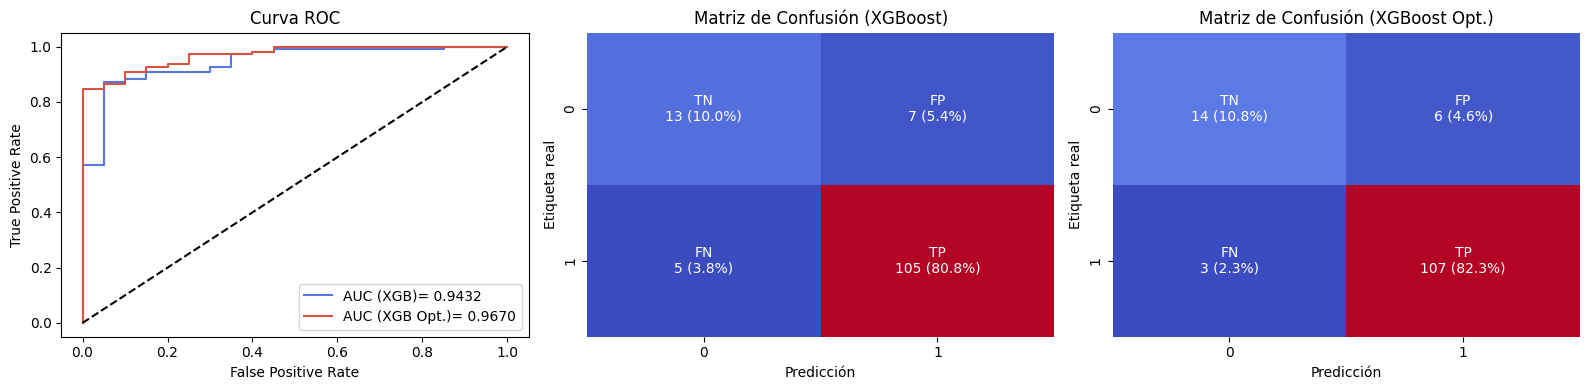

In [25]:
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_prob_xgb)
fpr_xgb_opt, tpr_xgb_opt, thresholds_xgb_opt = roc_curve(y_test, y_prob_xgb_opt)

plt.figure(figsize=(16, 4))

plt.subplot(1,3,1)
plt.step(fpr_xgb, tpr_xgb, label=f'AUC (XGB)= {roc_auc_xgb:.4f}', color=cmap(0.1))
plt.step(fpr_xgb_opt, tpr_xgb_opt, label=f'AUC (XGB Opt.)= {roc_auc_xgb_opt:.4f}', color=cmap(0.9))
plt.plot([0,1], [0,1], 'k--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()

cm = confusion_matrix(y_test, y_pred_xgb)
cm_percent = cm / cm.sum() * 100
labels = np.array([["TN", "FP"], ["FN", "TP"]])
annot = np.empty_like(cm).astype(str)
for i in range(2):
    for j in range(2):
        annot[i, j] = f"{labels[i, j]}\n{cm[i, j]} ({cm_percent[i, j]:.1f}%)"
plt.subplot(1,3,2)
sns.heatmap(cm, annot=annot, fmt='', cmap='coolwarm', cbar=False)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta real')
plt.title('Matriz de Confusión (XGBoost)')

cm = confusion_matrix(y_test, y_pred_xgb_opt)
cm_percent = cm / cm.sum() * 100
labels = np.array([["TN", "FP"], ["FN", "TP"]])
annot = np.empty_like(cm).astype(str)
for i in range(2):
    for j in range(2):
        annot[i, j] = f"{labels[i, j]}\n{cm[i, j]} ({cm_percent[i, j]:.1f}%)"
plt.subplot(1,3,3)
sns.heatmap(cm, annot=annot, fmt='', cmap='coolwarm', cbar=False)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta real')
plt.title('Matriz de Confusión (XGBoost Opt.)')

plt.tight_layout()
plt.show()

Como en el caso anterior, el área bajo la curva ROC del modelo optimizado es mayor. Al analizar las matrices, se observa una disminución en el número de falsos positivos (FP), es decir, alumnos clasificados como aprobados que en realidad están desaprobados.

Ambos modelos detectan los verdaderos positivos (TP), pero en ciertos contextos resulta más relevante evaluar qué tan bien un modelo identifica los falsos negativos (FN) y los falsos positivos (FP). Recordemos que este conjunto de datos se creó con el objetivo de comprender por qué los alumnos en Portugal desaprueban, por lo tanto, es más importante detectar a los alumnos desaprobados y, según las variables, entender las razones de su desaprobación que enfocarse únicamente en los que aprueban.

### Support Vector Machine

El objetivo de este algoritmo es econtrar un hiperplano que, en la mejor medida posible, separe los datos de una clase de los de otra clase. Este hiperplano puede ser una linea o un plano de n dimenesiones. SVM se encarga de encontrar la mejor solución, dentro de los infinitos hiperplanos para cada caso. Para esto busca el margen más grande entre clases a separar. 

Este algoritmo se basa en distancia entre puntos, por lo tango, es necesario escalar los datos mediante `StandardScaler()`.

In [26]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Luego, se instancia el modelo y se evalúa mediante 10 folds:

In [27]:
svm = SVC(kernel='rbf', probability=True, random_state=random_state) # Kernel es el tipo de función que se utiliza para transformar los datos en un espacio de mayor dimensión, donde es más fácil encontrar un hiperplano que separe las clases. 

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

scores = cross_validate(
    svm,
    X_train,
    y_train,
    cv=cv,
    scoring=['roc_auc', 'f1'],
    return_train_score=False

)

metrics_table = [
    ["ROC-AUC", [f"{v:.4f}" for v in scores['test_roc_auc']], f"{scores['test_roc_auc'].mean():.4f}"],
    ["F1 Score", [f"{v:.4f}" for v in scores['test_f1']], f"{scores['test_f1'].mean():.4f}"]
]

print(tabulate(metrics_table, headers=["Métrica", "Scores por fold", "Media"], tablefmt="github"))

| Métrica   | Scores por fold                                                                                      |   Media |
|-----------|------------------------------------------------------------------------------------------------------|---------|
| ROC-AUC   | ['0.9517', '0.9830', '0.9830', '0.9659', '0.9659', '0.9915', '0.9943', '0.9773', '0.9858', '0.8953'] |  0.9694 |
| F1 Score  | ['0.9451', '0.9655', '0.9545', '0.9663', '0.9425', '0.9778', '0.9778', '0.9565', '0.9263', '0.9663'] |  0.9579 |


In [28]:
svm.fit(X_train_scaled, y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


Para la búsqueda de hiperparámetros en el modelo SVM se siguió el mismo procedimiento que los autores: la optimización del valor de `gamma`. Este parámetro controla la influencia de cada muestra de entrenamiento en la definición de la frontera de decisión:

- Un valor de gamma pequeño genera una frontera más suave y general, lo que puede reducir el sobreajuste pero incrementar los errores de clasificación.

- Un valor de gamma grande produce una frontera más compleja y ajustada a los datos de entrenamiento, lo que puede mejorar la precisión local pero aumentar el riesgo de sobreajuste.

In [29]:
param_svm = {
    'gamma': Real(1e-4, 1e-1, prior='log-uniform')
}

svm_opt = BayesSearchCV(
    estimator=svm,
    search_spaces=param_svm,
    n_iter=30,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    random_state=random_state,
    verbose=1
)

svm_opt.fit(X_train_scaled, y_train)

print("Mejores hiperparámetros encontrados:")
print(xgb_opt.best_params_)
print(f"ROC-AUC: {svm_opt.best_score_:.4f}")

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for eac

In [30]:
svm_opt

,estimator,SVC(probabili...andom_state=6)
,search_spaces,{'gamma': Real(low=0.00...m='normalize')}
,optimizer_kwargs,None
,n_iter,30
,scoring,'roc_auc'
,fit_params,None
,n_jobs,-1
,n_points,1
,iid,'deprecated'
,refit,True
,cv,StratifiedKFo... shuffle=True)


In [31]:
y_prob_svm = svm.predict_proba(X_test_scaled)[:, 1]
y_pred_svm = svm.predict(X_test_scaled)

y_prob_svm_opt = svm_opt.predict_proba(X_test_scaled)[:, 1]
y_pred_svm_opt = svm_opt.predict(X_test_scaled)

roc_auc_svm = roc_auc_score(y_test, y_prob_svm)
f1_svm = f1_score(y_test, y_pred_svm)

roc_auc_svm_opt = roc_auc_score(y_test, y_prob_svm_opt)
f1_svm_opt = f1_score(y_test, y_pred_svm_opt)

print("Support Vector Machine:\n")

print(f"ROC-AUC:\t{roc_auc_svm:.4f}")
print(f"ROC-AUC (Opt.):\t{roc_auc_svm_opt:.4f}")
print(f"F1:\t\t{f1_svm:.4f}")
print(f"F1 (Opt.):\t{f1_svm_opt:.4f}")

Support Vector Machine:

ROC-AUC:	0.9427
ROC-AUC (Opt.):	0.9614
F1:		0.9558
F1 (Opt.):	0.9689


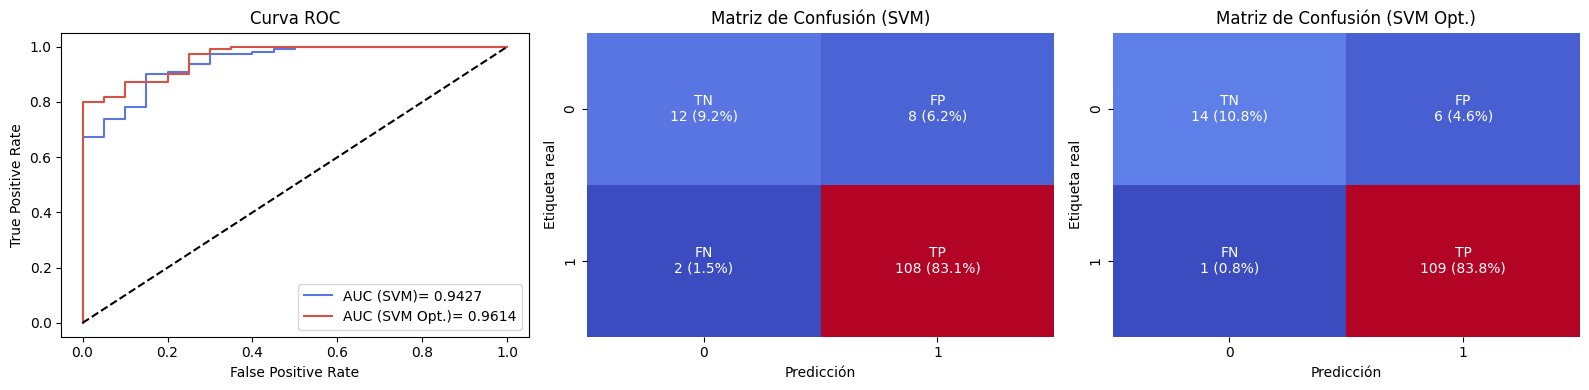

In [32]:
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, y_prob_svm)
fpr_svm_opt, tpr_svm_opt, thresholds_svm_opt = roc_curve(y_test, y_prob_svm_opt)

plt.figure(figsize=(16,4))

plt.subplot(1,3,1)
plt.step(fpr_svm, tpr_svm, label=f'AUC (SVM)= {roc_auc_svm:.4f}', color=cmap(0.1))
plt.step(fpr_svm_opt, tpr_svm_opt, label=f'AUC (SVM Opt.)= {roc_auc_svm_opt:.4f}', color=cmap(0.9))
plt.plot([0,1], [0,1], 'k--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()

cm = confusion_matrix(y_test, y_pred_svm)
cm_percent = cm / cm.sum() * 100
labels = np.array([["TN", "FP"], ["FN", "TP"]])
annot = np.empty_like(cm).astype(str)
for i in range(2):
    for j in range(2):
        annot[i, j] = f"{labels[i, j]}\n{cm[i, j]} ({cm_percent[i, j]:.1f}%)"
plt.subplot(1,3,2)
sns.heatmap(cm, annot=annot, fmt='', cmap='coolwarm', cbar=False)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta real')
plt.title('Matriz de Confusión (SVM)')

cm = confusion_matrix(y_test, y_pred_svm_opt)
cm_percent = cm / cm.sum() * 100
labels = np.array([["TN", "FP"], ["FN", "TP"]])
annot = np.empty_like(cm).astype(str)
for i in range(2):
    for j in range(2):
        annot[i, j] = f"{labels[i, j]}\n{cm[i, j]} ({cm_percent[i, j]:.1f}%)"
plt.subplot(1,3,3)
sns.heatmap(cm, annot=annot, fmt='', cmap='coolwarm', cbar=False)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta real')
plt.title('Matriz de Confusión (SVM Opt.)')

plt.tight_layout()
plt.show()

El valor de ROC-AUC es similar a los anteriores modelos pero lo que presente distinto el modelo optimizado es que redujo considerablemente el valor de falsos negativos (FN). Esto indica que el modelo identifica correctamente a los alumnos aprobados.

## Aprendizaje No Supervisado

En el aprendizaje no supervisado no se dispone de etiquetas conocidas, en su lugar, el objetivo es **descubrir patrones, estructuras o relaciones ocultas en los datos**. Dentro de este enfoque, uno de los métodos más utilizados es **K-means**, un algoritmo de clustering que agrupa las observaciones en función de su similitud.

In [33]:
df_ul = df.copy()
df_ul.sample(5)

,studytime,failures,schoolsup,famsup,paid,activities,higher,internet,absences,G1,G2,G3
227,2,0,0,1,0,1,1,1,10,12,11,11
642,2,0,0,0,0,0,1,1,0,6,9,11
548,2,0,0,0,0,1,1,1,2,11,10,11
87,3,0,0,1,0,1,1,1,4,15,15,15
435,2,0,0,1,0,0,1,1,0,10,10,10


### K-Means

*Exclusive Clustering* es una forma de agrupamiento que establece que cada punto de datos solo puede pertenecer a un único clúster. A este enfoque también se lo denomina *hard clustering*.

Un ejemplo clásico es el método **K-means**, en el cual los datos se asignan a K grupo, siendo K el número de clústeres definido previamente, en función de la distancia al centroide de cada grupo. Los puntos de datos más cercanos a un centroide se agrupan en la misma categoría.

El valor de K determina el nivel de granularidad del análisis:

- Un K grande genera clústeres más pequeños y específicos.

- Un K pequeño produce clústeres más amplios y generales.

Antes de definir los clusters, es recomendable escaladar los datos: 

In [34]:
k_df = df_ul.copy()
scaler = StandardScaler()
k_scaled = scaler.fit_transform(df_ul)

Para definir el número de clústers existen varios métodos, uno es el coeficiente de *Silhouette*. Permite evalular la separacion entre clústeres, asignando valores entre -1 y +1. Valores cercanos a +1 indican que la muestra está lejos de los clústers. Un valor 0 indica que la muestra se encuentra muy cerca del límite entre dos clústers, y valores negativos indican que esos datos podrían estar en el clúster equivocado.

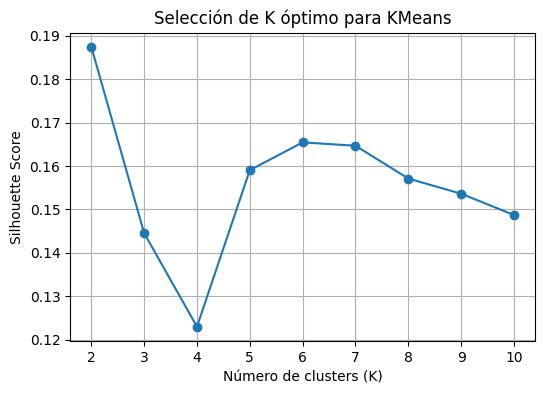

In [35]:
silhouette_scores = []
k_values = range(2, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=random_state)
    labels = kmeans.fit_predict(k_scaled)
    score = silhouette_score(k_scaled, labels)
    #print(f"{k}: {score}")
    silhouette_scores.append(score)
    
plt.figure(figsize=(6, 4))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel("Número de clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Selección de K óptimo para KMeans")
plt.grid(True)
plt.show()

En este caso, el número óptimo de clústeres resultó ser K = 2, aunque este valor no es muy elevado según el análisis. Esto sugiere que los datos no presentan una separación muy marcada entre sí.

Otro método para determinar el número adecuado de clústeres es el método del **codo** (elbow). Este consiste en evaluar la calidad del agrupamiento midiendo la suma de los errores cuadráticos dentro de cada clúster, es decir, la suma de las distancias al cuadrado entre cada punto de datos y su centroide. A medida que aumenta K, este valor disminuye, sin embargo, llega un punto en el que la mejora se vuelve marginal. Ese “codo” en la curva indica un buen compromiso entre complejidad y representatividad.

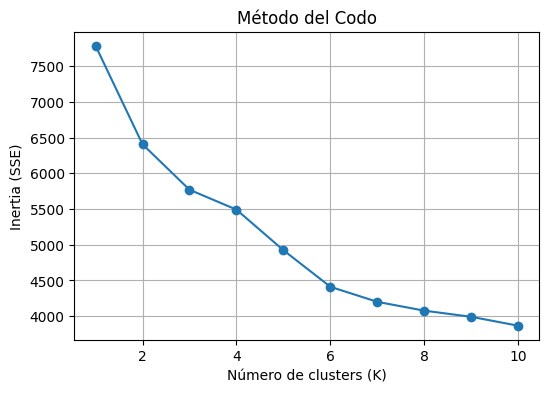

In [36]:
inertia_values = []
k_values = range(1, 11)  

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=random_state)
    kmeans.fit(k_scaled)
    inertia_values.append(kmeans.inertia_)
    #print(f"{k}: {kmeans.inertia_}")

plt.figure(figsize=(6, 4))
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Número de clusters (K)')
plt.ylabel('Inertia (SSE)')
plt.title('Método del Codo')
plt.grid(True)
plt.show()

En este caso, lo razonable sería probar con K=2, 3 y 4, comparar visualmente y elegir el que tenga mejor equilibrio entre interpretación y separación.

Se entrena el modelo de K-means con `K=3` para visualizar los resultados en un espacio 3D con las variables `G1`, `G2` y `G3`: 

In [37]:
kmeans = KMeans(n_clusters=3, random_state=random_state)
clusters = kmeans.fit_predict(k_scaled)

k_df["cluster"] = clusters
k_df["cluster"] = k_df["cluster"].astype(str)

fig = px.scatter_3d(
    k_df,
    x="G1",
    y="G2", 
    z="G3",   
    color="cluster",
    title="K-Means 3D",
    symbol="cluster",
    size_max=10,
    color_discrete_sequence=px.colors.qualitative.Set1,
)

fig.update_layout(
    legend_title_text="Cluster",
    hovermode="closest",
    width=1200,
    height=800,
    scene_camera=dict(eye=dict(x=-1.5, y=1.5, z=1.5)),
)
fig.update_traces(
    marker=dict(size=5)
)  

En el gráfico se pueden ver tres grupos:

- Alumnos Aprobados
- Alumnos Desaprobados
- Alumnos con una nota muy cercada al mínimo

Los métodos *Silhouette* y *Elbow* ayudan a estimar el número de clústers pero si los valores obtenidos en estos métodos no son muy buenos, no siginifica que K-Means no funciones. Se obtendran clústers superpuestos o con poca separación.

#### PCA

Otro método de aprendizaje no supervisado es la reduccion de dimensionalidad PCA. Esto se puede aplicar en conjunto con K-Means. Aplicar K-Means + PCA no cambia la esencia de los clústers pero ayuda a vizualizar los clústers.

Se buscan los primeros dos componentes principales y se grafican:

In [38]:
pca = PCA(n_components=2)
data_pca = pca.fit_transform(k_scaled)

k_df["PCA1"] = data_pca[:, 0]  
k_df["PCA2"] = data_pca[:, 1]  

fig = px.scatter(
    k_df,
    x="PCA1",
    y="PCA2",
    color="cluster",
    title="K-Means + PCA",
    hover_data=["studytime", "failures", "absences", "schoolsup", "famsup", "paid", "activities", "higher", "internet", "G1", "G2", "G3"],
    labels={"PCA1": "Componente Principal 1", "PCA2": "Componente Principal 2"},
    color_discrete_sequence=px.colors.qualitative.Set1,
)

fig.update_layout(
    legend_title_text="Cluster",
    hovermode="closest",
    width=1200,
    height=800
)

fig.update_traces(
    marker=dict(size=10)
)  

En este gráfico son evidentes los clústers, presentan solapamiento entre ellos, pero aun se puede apreciar lo mismo.

Finalmente se puede utilizar otra métrica para evaluar los clústers llamada *Davies-Bouldin*. Mientras más bajo sea el valor, mejor será la separación entre clústers. 

In [39]:
db_score = davies_bouldin_score(k_scaled, clusters)
print(f"Davies-Bouldin Score: {db_score:.4f}")

Davies-Bouldin Score: 2.0802


## Conclusiones 

La elección de un modelo de aprendizaje automático depende directamente del objetivo que se persigue. En este caso, los autores buscaban identificar las razones por las que los alumnos desaprueban. Para ello, se emplearon modelos de clasificación que permiten separar a los estudiantes en dos grupos: aprobados y no aprobados, en función de sus características individuales.

Este análisis resulta especialmente interesante porque ayuda a comprender los factores que influyen en el rendimiento académico y, por lo tanto, en la probabilidad de aprobar o desaprobar.

De manera complementaria, el uso de métodos de clustering ofrece otra perspectiva: sin necesidad de utilizar la calificación final como etiqueta, los alumnos pueden agruparse en categorías como aprobados, desaprobados y aquellos que se encuentran en un punto intermedio, muy cercada al mínimo.

Finalmente, para evaluar el desempeño de los modelos y poder determinar cuál es más adecuado en este tipo de tareas, resulta fundamental seleccionar correctamente las métricas y comprender cuál es la más apropiada en cada caso.

# Recursos

- [Scikit-learn: Árboles de decisión](https://scikit-learn.org/stable/modules/tree.html#tree)  
- [NVIDIA Developer: 7 Drop-in Replacements to Instantly Speed Up Your Python Data Science Workflows](https://developer.nvidia.com/blog/7-drop-in-replacements-to-instantly-speed-up-your-python-data-science-workflows/?linkId=100000376196126)  
- [Towards Data Science: Data Scaling 101 – Standardization and Min-Max Scaling Explained](https://towardsdatascience.com/data-scaling-101-standardization-and-min-max-scaling-explained-60789833e160/)  
- [Machine Learning Mastery: Train-Test Split for Evaluating Machine Learning Algorithms](https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/)  
- [Scikit-learn: Common Pitfalls](https://scikit-learn.org/stable/common_pitfalls.html)  
- [Google Developers: Accuracy, Precision, and Recall](https://developers.google.com/machine-learning/crash-course/classification/accuracy-precision-recall?hl=es-419)  
- [Machine Learning Mastery: Tour of Evaluation Metrics for Imbalanced Classification](https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/)  
- [Google Developers: ROC and AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc?hl=es-419)  
- [Scikit-learn: Tutorial de Aprendizaje No Supervisado](https://scikit-learn.org/1.2/tutorial/statistical_inference/unsupervised_learning.html)  
- [Towards Data Science: Understanding L1 and L2 Regularization (Part 1)](https://towardsdatascience.com/understanding-l1-l2-regularization-part-1-9c7affe6f920/)  
- [IBM: Gradient Boosting](https://www.ibm.com/think/topics/gradient-boosting#:~:text=Gradient%20boosting%20is%20a%20machine,minimize%20errors%20and%20improve%20accuracy.)  
- [MathWorks: Support Vector Machine](https://la.mathworks.com/discovery/support-vector-machine.html)  
- [Scikit-learn: Ejemplos de Kernels en SVM](https://scikit-learn.org/stable/auto_examples/svm/plot_svm_kernels.html#sphx-glr-auto-examples-svm-plot-svm-kernels-py)  
- [YouTube: ROC and AUC, Clearly Explained!](https://www.youtube.com/watch?v=4jRBRDbJemM)
